In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_excel('C:/Datasets/Zetta/renewed_data.xlsx')

#### Зададим количество отображаемых строк и столбцов

In [3]:
pd.set_option('display.max_columns', 200)
pd.set_option('max_rows', 500)

In [4]:
df.head()

,ID,Make,Model,Power,Price,Is_credit,Begin_month,End_month,Is_renewed,Years_renewed,Price_change,Sales_channel,Fillial,Agent,Min_age,Min_exp,M_F,Region,OSAGO,Deductible
0,1000000301,Kia,Ceed,129.0,614500.0,1,2,2,0,1,0.04,52,Санкт-Петербург,245.0,58,4,F,Санкт-Петербург,1,0.0
1,1000034155,Ford,Focus,125.0,708000.0,1,4,4,1,0,-0.28,52,Санкт-Петербург,493.0,52,18,F,Мурманская,0,15000.0
2,1000036840,Mitsubishi,Pajero,178.0,900000.0,0,10,10,1,0,-0.01,50,Москва,NaN,41,17,M,Москва,0,20000.0
3,1000055374,Subaru,Outback,167.0,1500000.0,0,1,1,1,0,-0.10,50,Москва,NaN,34,15,M,Москва,0,10000.0
4,1000070327,Ford,Mondeo,199.0,814302.0,1,6,6,0,3,-0.21,52,Санкт-Петербург,1096.0,43,17,M,Санкт-Петербург,0,20000.0


#### Выведем пропуски

In [5]:
df.isnull().sum()

ID                   0
Make                 0
Model                0
Power                0
Price                0
Is_credit            0
Begin_month          0
End_month            0
Is_renewed           0
Years_renewed        0
Price_change         0
Sales_channel        0
Fillial              0
Agent            12699
Min_age              0
Min_exp              0
M_F                  0
Region             574
OSAGO                0
Deductible           0
dtype: int64

#### Посмотрим на количество уникальных значений по каждому предиктору

In [6]:
for i in df.columns:
    print(i, df[i].nunique())

ID 54481
Make 78
Model 510
Power 325
Price 28293
Is_credit 2
Begin_month 12
End_month 12
Is_renewed 2
Years_renewed 11
Price_change 377
Sales_channel 63
Fillial 2
Agent 1219
Min_age 68
Min_exp 109
M_F 2
Region 81
OSAGO 2
Deductible 157


#### Удалим переменную ID как не информативную

In [7]:
df.drop('ID', axis = 1, inplace = True)

#### Выведем дубли

In [8]:
df[df.duplicated()]

,Make,Model,Power,Price,Is_credit,Begin_month,End_month,Is_renewed,Years_renewed,Price_change,Sales_channel,Fillial,Agent,Min_age,Min_exp,M_F,Region,OSAGO,Deductible
16364,Volkswagen,Jetta,105.0,596000.0,1,8,8,0,0,0.00,52,Санкт-Петербург,330.0,40,20,M,Ленинградская,1,15000.0
31866,Chevrolet,Cruze,109.0,553105.0,0,7,7,0,0,-1.00,27,Москва,696.0,40,15,M,Москва,1,30000.0
40926,Toyota,Другая модель (Легковое ТС),146.0,1512000.0,0,4,4,0,0,0.18,55,Москва,1096.0,36,17,F,Москва,1,0.0
41381,Daewoo,Gentra,107.0,439000.0,1,5,5,0,0,-1.00,52,Санкт-Петербург,782.0,44,22,M,Ленинградская,1,15000.0


#### Удалим дубли на месте

In [9]:
df.drop_duplicates(subset=None, keep='first',inplace=True)

#### Построим матрицу корелляции предикторов для выявления сильно кореллирующих предикторов между собой

In [10]:
corr_matrix = df.corr()

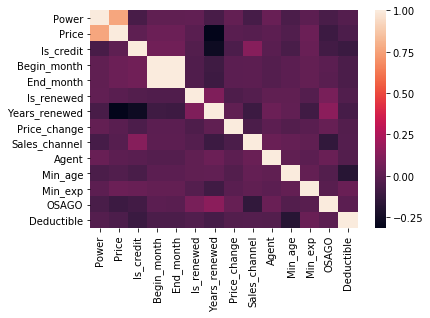

In [11]:
import seaborn as sns
sns.heatmap(corr_matrix);

#### Удалим один из предикторов - Begin_month или End_month, поскольку они кореллируют между собой. Корелляция очень сильная - 0.99

In [12]:
df.drop('End_month', axis = 1, inplace = True)

#### Предикторы Agent, Begin_month, Sales_channel по факту являются категориальными. Выполним соответсвующие преобразования.

In [13]:
df['Agent'] = df['Agent'].astype('object', copy = False)
df['Sales_channel'] = df['Sales_channel'].astype('object', copy = False)
df['Begin_month'] = df['Begin_month'].astype('object', copy = False)

#### Импутируем пропуски в переменных Agent и Region

In [14]:
df['Agent'].fillna('NOT_AGENT', inplace = True) # Поскольку в Agent пропуск скорее всего не случаен и означает, что продажу осуществил не агент.
df['Region'].fillna('Unknown_region', inplace = True)

#### Произведем укрупнение редких категорий

In [15]:
for i in ['Make', 'Model', 'Agent', 'Sales_channel', 'Region']:
    for j in df[i].unique():
        if df[df[i] == j][i].count() < 20:
            df[i].replace(j, 'OTHER', inplace = True)       

In [16]:
# Переведем категориальную переменную M_F в бинарную (1, 0). 
df['M_F'] =  df['M_F'].map(lambda x: 1 if x == 'M' else 0)

In [17]:
# Также добавим индикатор пропуска в предикторе Agent
df['Is_Agent'] =  df['Agent'].map(lambda x: 1 if x == 'NOT_AGENT' else 0)

In [18]:
# Создадим также индикатор уменьшения/увеличения премии признака Price_change для случаев >0 <0 и равно 0.
df['Price_change_ABC'] =  df['Price_change'].map(lambda x: np.sign(x) if x !=0 else 0)

In [19]:
# а также индикатор стоимости франшизы - 0 и не 0.
df['Deductible_Is_Zero'] = df['Deductible'].map(lambda x: 1 if x==0 else 0)

In [20]:
# Min_exp - скорее всего косяк в указании года. Если год > 1900 - заменить значение в ячейке с i на (2018 - i)
df['Min_exp'] = df['Min_exp'].map(lambda x: x if x<1900 else (2018-x))

#### Сделаем биннинг количественных переменных: Power, Price,  Min_age, Min_exp

In [21]:
# разобьем наш датасет на обучение и тест
train = df.sample(frac = 0.7, random_state = 200)
test = df.drop(train.index)

In [22]:
# Создадим новый признак Power_tax, который отражает коэффициент налогообложения
bins_Power = [-np.inf, 100, 150, 200, 250, np.inf]

train['Power_tax'] = pd.cut(train['Power'], bins_Power)
test['Power_tax'] = pd.cut(test['Power'], bins_Power)

In [23]:
# Создадим новый признак Power_OSAGO, который отражает коэффициент мощности для расчета OSAGO. 
# Если OSAGO нет, то можно поставить 0 в данном признаке.
bins_OSAGO = [-np.inf, 70, 100, 120, 150, np.inf]

train['Power_OSAGO'] = pd.cut(train['Power'], bins_OSAGO)
test['Power_OSAGO'] = pd.cut(test['Power'], bins_OSAGO)

In [24]:
train['Power_OSAGO'].value_counts()

(120.0, 150.0]    16466
(150.0, inf]      12246
(100.0, 120.0]     6547
(70.0, 100.0]      2742
(-inf, 70.0]        133
Name: Power_OSAGO, dtype: int64

In [25]:
# Присвоим каждой категории соответствующее численное значение.
dict_tax = {'(-inf, 100.0]':2.5,
               '(100.0, 150.0]':3.5,
               '(150.0, 200.0]':5, 
               '(200.0, 250.0]':7.5,
               '(250.0, inf]':15}

train['Power_tax'] = train['Power_tax'].astype('str', copy = False)
test['Power_tax'] = test['Power_tax'].astype('str', copy = False)

train['Power_tax'] = train['Power_tax'].map(dict_tax)
test['Power_tax'] = test['Power_tax'].map(dict_tax)

In [26]:
dict_OSAGO = {'(-inf, 70.0]':0.6,
               '(70.0, 100.0]':1.1,
               '(100.0, 120.0]':1.2, 
               '(120.0, 150.0]':1.4,
               '(150.0, inf]':1.6}

train['Power_OSAGO'] = train['Power_OSAGO'].astype('str', copy = False)
test['Power_OSAGO'] = test['Power_OSAGO'].astype('str', copy = False)

train['Power_OSAGO'] = train['Power_OSAGO'].map(dict_OSAGO)
test['Power_OSAGO'] = test['Power_OSAGO'].map(dict_OSAGO)

In [27]:
# Выполним биннинг признака Price на основании градации цены автомобиля
bins_Price = [-np.inf, 600000, 1100000, 1600000, 2700000, np.inf]

train['Price_bins'] = pd.cut(train['Price'], bins_Price)
test['Price_bins'] = pd.cut(test['Price'], bins_Price)

train['Price_bins'] = train['Price_bins'].astype('str', copy = False)
test['Price_bins'] = test['Price_bins'].astype('str', copy = False)

In [28]:
# Выполним кодирование переменных Price_bins и Price_change_ABC
for i in ['Price_bins', 'Price_change_ABC']:
    freq_encoding = train[i].value_counts() / len(train[i])
    train[i + 'freq'] = train[i].map(freq_encoding)
    test[i + 'freq'] = test[i].map(freq_encoding)

In [29]:
# Удалим соответствующие столбцы, для которых уже произведено кодирование
train.drop(['Price_bins', 'Price_change_ABC'], axis = 1, inplace = True)
test.drop(['Price_bins', 'Price_change_ABC'], axis = 1, inplace = True)

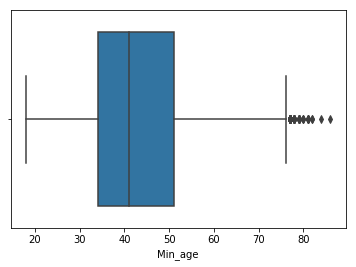

In [30]:
# Выполним биннинг признака Min_age. Построим график boxplot
sns.boxplot(train['Min_age']);

C:\Users\mi\Anaconda3\lib\site-packages\scipy\stats\stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


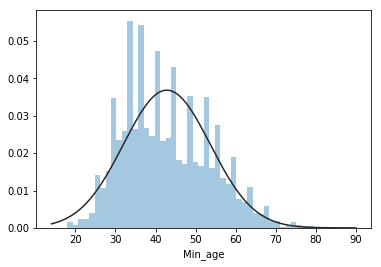

In [31]:
# Построим распределение данного признака
from scipy.stats import norm
sns.distplot(train['Min_age'], fit=norm, kde=False);

In [32]:
# Выполним биннинг данного признака
bins_Age = [17, 26, 33, 38, 45, 55, np.inf]

train['Min_age_bins'] = pd.cut(train['Min_age'], bins_Age)
test['Min_age_bins'] = pd.cut(test['Min_age'], bins_Age)

train['Min_age_bins'] = train['Min_age_bins'].astype('str', copy = False)
test['Min_age_bins'] = test['Min_age_bins'].astype('str', copy = False)

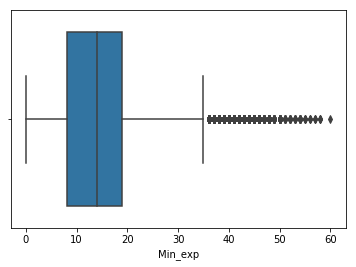

In [33]:
# Выполним биннинг признака Min_exp. Построим график boxplot
sns.boxplot(train['Min_exp']);

C:\Users\mi\Anaconda3\lib\site-packages\scipy\stats\stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


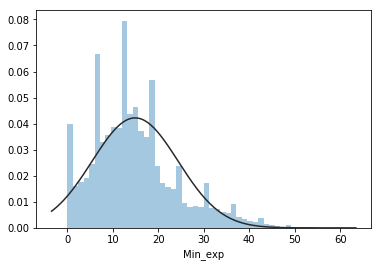

In [34]:
# Построим распределение данного признака
sns.distplot(train['Min_exp'], fit=norm, kde=False);

In [35]:
bins_Exp = [-np.inf, 9, 13, 18, 25, 35, np.inf]

train['Min_exp_bins'] = pd.cut(train['Min_exp'], bins_Exp)
test['Min_exp_bins'] = pd.cut(test['Min_exp'], bins_Exp)

train['Min_exp_bins'] = train['Min_exp_bins'].astype('str', copy = False)
test['Min_exp_bins'] = test['Min_exp_bins'].astype('str', copy = False)

In [36]:
# Закодируем получившиеся категориальные переменные
for i in ['Min_age_bins', 'Min_exp_bins']:
    freq_encoding = train[i].value_counts() / len(train[i])
    train[i + 'freq'] = train[i].map(freq_encoding)
    test[i + 'freq'] = test[i].map(freq_encoding)

In [37]:
# Удалим закодированные переменные
train.drop(['Min_age_bins', 'Min_exp_bins'], axis = 1, inplace = True)
test.drop(['Min_age_bins', 'Min_exp_bins'], axis = 1, inplace = True)

In [38]:
# Заменим значения категориальной переменной Filial на 0 и 1 
dict_Fillial = {'Москва':1,
               'Санкт-Петербург':0}

train['Fillial'] = train['Fillial'].astype('str', copy = False)
test['Fillial'] = test['Fillial'].astype('str', copy = False)

train['Fillial'] = train['Fillial'].map(dict_Fillial)
test['Fillial'] = test['Fillial'].map(dict_Fillial)

#### Выполним кодирование средним значением целевой переменной по категории для признаков: 'Make', 'Model', 'Agent', 'Sales_channel', 'Region', 'Begin_month', 'Price_binsfreq', 'Price_change_ABCfreq', 'Min_age_binsfreq', 'Min_exp_binsfreq'

In [39]:
cat_list = ['Make', 'Model', 'Agent', 'Sales_channel', 'Region', 'Begin_month', 
            'Price_binsfreq', 'Price_change_ABCfreq', 'Min_age_binsfreq', 'Min_exp_binsfreq']

for i in cat_list:
    train[i + ' mean'] = train[i].map(train.groupby(i)['Is_renewed'].mean())
    test[i + ' mean'] = test[i].map(train.groupby(i)['Is_renewed'].mean())

In [40]:
# Удалим соответствующие столбцы
train.drop(['Make', 'Model', 'Agent', 'Sales_channel', 'Region'], axis = 1, inplace = True)
test.drop(['Make', 'Model', 'Agent', 'Sales_channel', 'Region'], axis = 1, inplace = True)

#### Выделим целевую переменную

In [41]:
y_train = train['Is_renewed']
train.drop('Is_renewed', axis=1, inplace = True)

y_test = test['Is_renewed']
test.drop('Is_renewed', axis=1, inplace = True)

#### Применим преобразование Бокса-Кокса для приведения численных признаков к нормальному виду.

In [42]:
from scipy.stats import boxcox

for i in ['Power', 'Price', 'Price_change', 'Min_age', 'Min_exp', 
          'Deductible', 'Price_binsfreq', 'Min_age_binsfreq', 
          'Min_exp_binsfreq', 'Make mean', 'Model mean', 'Agent mean', 
         'Sales_channel mean', 'Region mean']:
    train[i].replace(0.0, 0.001, inplace = True) # Заменяем 0 на стремящееся к нулю значение
    transformed, lam = boxcox(np.absolute(train[i]))
    print('predictor:', i, 'Lambda: %f' % lam)
    if lam < -0.25:
        train[i] = np.sign(train[i]) * (np.absolute(train[i])** (-1/2))
        test[i] = np.sign(test[i]) * (np.absolute(test[i])** (-1/2))
    if -0.25 <= lam <= 0.25:
        train[i] = np.log(np.absolute(train[i])+ 0.001)
        test[i] = np.log(np.absolute(test[i])+ 0.001)
    if 0.25 < lam < 0.75:
        train[i] = np.sign(train[i]) * (np.absolute(train[i])** (1/2))
        test[i] = np.sign(test[i]) * (np.absolute(test[i])** (1/2))

predictor: Power Lambda: 0.199787
predictor: Price Lambda: 0.170121
predictor: Price_change Lambda: 0.153142
predictor: Min_age Lambda: 0.149378
predictor: Min_exp Lambda: 0.529827
predictor: Deductible Lambda: -0.076371
predictor: Price_binsfreq Lambda: 1.698806
predictor: Min_age_binsfreq Lambda: 2.725047
predictor: Min_exp_binsfreq Lambda: 1.240343
predictor: Make mean Lambda: 5.082563
predictor: Model mean Lambda: 2.096813
predictor: Agent mean Lambda: 2.547591
predictor: Sales_channel mean Lambda: 2.424381
predictor: Region mean Lambda: 5.075119


#### Выполним стандартизацию (масштабирование) признаков

In [43]:
from sklearn.preprocessing import StandardScaler
 
scaler = StandardScaler()

scaler.fit(train)

train_s = scaler.transform(train)
test_s = scaler.transform(test)

#### Для начала построим модель логистической регрессии. В качестве метрики будем использовать величину AUC_ROC.

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

logreg_grid = LogisticRegression(penalty = 'l2', solver = 'lbfgs') # параметры C и 'l2' были также ранее подобраны на кросс-валидации

param_grid = {'C': [0.9, 0.92, 0.94, 0.96, 0.98, 1.02, 1.04, 1.06, 1.08]} # Задаем решетку гиперпараметров. 

stratcv = StratifiedKFold(n_splits=5) # Указываем количество блоков для кросс-валидации.

#создаем экземпляр класса GridSearchCV
grid_search = GridSearchCV(logreg_grid, param_grid, 
                           scoring='roc_auc', 
                           n_jobs=-1, cv=stratcv)

grid_search.fit(train_s, y_train)

test_score = roc_auc_score(y_test, grid_search.predict_proba(test_s)[:, 1])
#смотрим результаты GridSearchCV
print('AUC на тестовой выборке: {:.3f}'.format(test_score))
print('Наилучшее значение гиперпараметров: {}'.format(grid_search.best_params_))
print('Наилучшее значение AUC: {:.3f}'.format(grid_search.best_score_))

AUC на тестовой выборке: 0.665
Наилучшее значение гиперпараметров: {'C': 1.08}
Наилучшее значение AUC: 0.686


#### Выведем коэффициенты построенной логистической регрессии

In [45]:
clf = LogisticRegression(penalty = 'l2', C = 1.08, solver = 'lbfgs')
clf.fit(train_s, y_train)

coefficients = pd.concat([pd.DataFrame(train.columns),pd.DataFrame(np.transpose(clf.coef_))], axis = 1)
coefficients.columns = ['Feature','Value']

In [46]:
coefficients.sort_values(by = 'Value')

,Feature,Value
11,Deductible,-1.743209
13,Deductible_Is_Zero,-1.651648
5,Price_change,-0.638728
12,Is_Agent,-0.049763
14,Power_tax,-0.048659
9,M_F,-0.035758
20,Make mean,-0.026503
18,Min_age_binsfreq,-0.019581
15,Power_OSAGO,-0.011695
7,Min_age,-0.007072


#### Из данной таблицы мы видим, что наибольший вклад в прогноз (прямая зависимость) вносят признаки - 'Price_change_ABCfreq', 'Price_change_ABCfreq mean', 'Agent mean', 'Years_renewed', 'Model mean', 'Region mean'. Из этого следует, что на прогноз влияют такие вещи, как уменьшение страховой премии, а также количество лет, которые клиент уже обслуживается в компании. Также определенный вклад в прогноз вносят наличие ОСАГО и мощность двигателя.

#### Из данной таблицы также видно, что такие предикторы как Deductible, Deductible_Is_Zero, Price_change - находятся вверху таблицы (наиболее отрицательные коэффициенты). Соответственно такие показатели как увеличение франшизы, а также увеличение страховой премии - уменьшают вероятность пролонгации договора.

#### Попробуем построить более сложную модель (возьмем градиентный бустинг)

In [47]:
import xgboost as XGB
Boost = XGB.XGBClassifier(n_jobs=-1, reg_alpha = 0.1, reg_lambda = 0.1,
                          min_samples_leaf = 2, min_samples_split = 5, learning_rate = 0.01, n_estimators = 700,
                          subsample = 0.9) # Гиперпараметры также несколько раз подбирались на кросс-валидации.

param_grid = {'max_depth' : [2,3,4,5,6,7,8]}

stratcv = StratifiedKFold(n_splits=5) 


grid_search = GridSearchCV(Boost, param_grid, 
                           scoring='roc_auc', 
                           n_jobs=-1, cv=stratcv)

grid_search.fit(train_s, y_train)

test_score = roc_auc_score(y_test, grid_search.predict_proba(test_s)[:, 1])

print('AUC на тестовой выборке: {:.3f}'.format(test_score))
print('Наилучшее значение гиперпараметров: {}'.format(grid_search.best_params_))
print('Наилучшее значение AUC: {:.3f}'.format(grid_search.best_score_))

AUC на тестовой выборке: 0.730
Наилучшее значение гиперпараметров: {'max_depth': 7}
Наилучшее значение AUC: 0.739


#### После построения модели также сделал следующие выводы:
#### 1. Предикторы Agent и Model могут нести некоторые модельные риски, поскольку со временем в нашем хранилище может появляться много новых редких категорий, которые не будут учтены в построенной ранее модели.
#### 2. Можно было бы добавить признаки - пробег авто; отметка о том, подержаное авто или нет, количество аварий у клиента, количество зарег. авто у клиента. Возможно, они смогут повысить качество модели.